In [3]:
import copy

import torch
import time
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val':transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    def __call__(self,img,phase):
        return self.data_transform[phase](img)

In [3]:
cat_directory = r'./dl_pytorch/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'./dl_pytorch/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory,f) for f in os.listdir(cat_directory)]) #경로.../cat01.jpg 로 합쳐줌
dog_images_filepaths = sorted([os.path.join(dog_directory,f) for f in os.listdir(dog_directory)])


images_filepaths = [*cat_images_filepaths,*dog_images_filepaths] # 경로 리스트 괄호 제거하고 넣어줌
correct_images_filepaths=[i for i in images_filepaths if cv2.imread(i) is not None] # 이미지 읽어지면 경로에 추가

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths),len(val_images_filepaths),len(test_images_filepaths))

400 92 10


In [27]:
cat_directory = r'./dl_pytorch/chap06/data/PetImages/Cat' ## 캐글에서 받은 2만장짜리 dataset으로 진행해보자
dog_directory = r'./dl_pytorch/chap06/data/PetImages/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory,f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory,f)for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths,*dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if (cv2.imread(i) is not None and cv2.imread(i).shape[-1]!=1)] # grayscale 파일 예외처리
random.seed(101)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:12000]
print(train_images_filepaths)
val_images_filepaths = correct_images_filepaths[12000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths),len(val_images_filepaths),len(test_images_filepaths))

KeyboardInterrupt: 

In [171]:
for path in images_filepaths:
    print(path)

./dl_pytorch/chap06/data/PetImages/Cat\0.jpg
./dl_pytorch/chap06/data/PetImages/Cat\1.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10.jpg
./dl_pytorch/chap06/data/PetImages/Cat\100.jpg
./dl_pytorch/chap06/data/PetImages/Cat\1000.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10000.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10001.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10002.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10003.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10004.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10005.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10006.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10007.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10008.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10009.jpg
./dl_pytorch/chap06/data/PetImages/Cat\1001.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10010.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10011.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10012.jpg
./dl_pytorch/chap06/data/PetImages/Cat\10013.jpg
./dl_pytorch/chap06/data/PetImages/

In [29]:
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows = len(images_filepaths)//cols
    figure,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,6))
    for i,image_filepath in enumerate(images_filepaths):
        image=cv2.imread(image_filepath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## 이미지 색상 변경. 입력 이미지의 색상이 BGR인데, RGB로 바꾸겠다
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] # 이미지 전체 경로 정규화. os.sep ->/ or \ 기준 나눔. 마지막에서 두번째 아이템->label
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label,color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

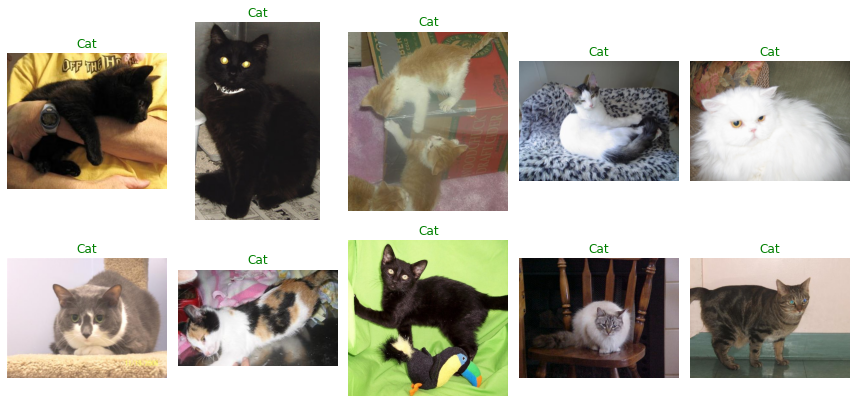

In [113]:
display_image_grid(test_images_filepaths)

In [4]:
class DogvsCatDataset(Dataset):
    def __init__(self,file_list,transform=None,phase='train'):
        self.file_list=file_list
        self.transform=transform ## 생성할 때 transform 매개변수 받아옴
        self.phase=phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img= img.convert('RGB') #이거 안해줘서 오류났을수도
        img_transformed = self.transform(img,self.phase)
        #label = img_path.split('\\')[-1].split('.')[0] ## string parsing. dog/cat 가져옴 - 예시용 splitting
        label = img_path.split('\\')[0].split('/')[-1] # 캐글에서 가져온 dataset용 label 추출
        if label=='Dog':
            label=1
        elif label=='Cat':
            label=0
        return img_transformed,label

In [5]:
size = 224
mean = (0.4,0.5,0.5)
std = (0.229,0.224,0.225)
batch_size = 32

In [6]:
train_dataset = DogvsCatDataset(train_images_filepaths,transform=ImageTransform(size,mean,std),phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths,transform=ImageTransform(size,mean,std),phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size()) ## img 출력
print(train_dataset.__getitem__(index)[1]) # label 출력

torch.Size([3, 224, 224])
0


In [7]:
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
dataloader_dict = {'train':train_dataloader,'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs,label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0])


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1 = nn.Conv2d(3,16,5,1,0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.cnn2 = nn.Conv2d(16,32,5,1,0)
        self.relu2=nn.ReLU()
        self.maxpool2=nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*53*53,512)
        self.relu5=nn.ReLU()
        self.fc2=nn.Linear(512,2)
        self.output=nn.Softmax(dim=1)

    def forward(self,x):
        out=self.cnn1(x)
        out=self.relu1(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.relu2(out)
        out=self.maxpool2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.output(out)
        return out


In [9]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [182]:
from torchsummary import summary
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [183]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [184]:
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [34]:
def train_model(model,dataloader_dict,criterion,optimizer,num_epoch):
    since = time.time()
    best_acc =0.0

    for epoch in range(num_epoch):
        print(f'Epoch{epoch+1}/{num_epoch}')
        print('-'*20)

        for phase in['train','val']:
            if phase =='train':
                model.train()
            else:
                model.eval()
            epoch_loss=0.0
            epoch_corrects=0

            for inputs,labels in tqdm(dataloader_dict[phase]):
                inputs =inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item()*inputs.size(0) ## 오차와 입력을 곱하는 이유? ->손실함수에 reduction parameter 디폴트 = mean 이기 때문. 전체 오차의 평균을 반환하기 때문에, loss를 계산하는 동안 배치 사이즈를 로스에 곱해줘야 한다.
                    epoch_corrects +=torch.sum(preds==labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double()/len(dataloader_dict[phase].dataset)

            print(f'{phase} Loss:{epoch_loss:.4f} Ac: {epoch_acc:.4f}')

            if phase=='val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    time_elapsed = time.time() -since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc:{best_acc:.4f}')
    return model


In [35]:
import time
num_epoch = 10
model = train_model(model,dataloader_dict,criterion,optimizer,num_epoch) # large dataset으로 하니까 밑에 나는 오류가 남. 왜 나는지 모르겠어서 일단 보류.

Epoch1/10
--------------------


C:\Users\user\AppData\Local\Temp\ipykernel_6252\330727393.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs,labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6932 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6931 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6929 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6931 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6930 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6931 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6929 Ac: 0.5109
Epoch7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6931 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6928 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6929 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6928 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Training complete in 0m 19s
Best val Acc:0.5109


In [67]:
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # test시에는 gradient 계산할 필요 없음
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id=test_path.split('\\')[-1].split('.')[1]
        transform = ImageTransform(size,mean,std)
        img = transform(img,phase='val')
        img = img.unsqueeze(0) # 차원 추가.
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs,dim=1)[:,1].tolist() #지정된 차원을 따라 텐서 정규화
        id_list.append(_id)
        pred_list.append(preds[0])

        res = pd.DataFrame({
            'id':id_list,
            'label':pred_list
        })
        res.sort_values(by='id',inplace=True)
        res.reset_index(drop=True,inplace=True)

        res.to_csv('./dl_pytorch/chap06/data/LeNet',index=False)

C:\Users\user\AppData\Local\Temp\ipykernel_11388\727557842.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
res.head(10)

,id,label
0,109,0.459550
1,145,0.444579
2,15,0.570344
3,162,0.471176
4,167,0.500501
5,200,0.417112
6,210,0.604288
7,211,0.549317
8,213,0.436797
9,224,0.527775


NameError: name 'res' is not defined

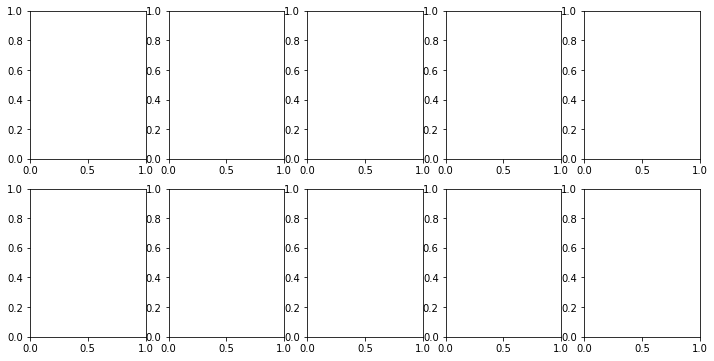

In [36]:
class_ = classes = {0:'cat',1:'dog'}
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows = len(images_filepaths)//cols
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,6))
    for i,images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id']==a,'label'].values[0]
        if label>0.5:
            label=1
        else:
            label=0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

6.1.2 Alexnet.

In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
train_imagenet_data = "C:/Users/user/PycharmProjects/TF-NAS/dataset/imagenet/train/"
test_imagenet_data = "C:/Users/user/PycharmProjects/TF-NAS/dataset/imagenet/test/"
train_data_loader= DataLoader(train_imagenet_data,batch_size=4,shuffle=True)
test_data_loader = DataLoader(test_imagenet_data,batch_size=4,shuffle=False)

In [10]:
batch_iterator = iter(train_data_loader)

In [11]:
class AlexNet(nn.Module):
    def __init__(self)->None:
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True), #inplace 연산의 의미->새로운 변수에 저장하는것이 아니라, 기존 데이터를 대체한다.(덮어쓰기)
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,2)
        )
    def forward(self,x:torch.Tensor)->torch.Tensor:
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

In [12]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [41]:
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [42]:
from torchsummary import summary
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [43]:
num_epoch=10
model = train_model(model,dataloader_dict,criterion,optimizer,num_epoch)

Epoch1/10
--------------------


C:\Users\user\AppData\Local\Temp\ipykernel_6252\330727393.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs,labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6928 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6932 Ac: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6926 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6928 Ac: 0.5109
Epoch4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6928 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6927 Ac: 0.5109
Epoch5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6929 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6927 Ac: 0.5109
Epoch6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6929 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6927 Ac: 0.5109
Epoch7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6925 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6927 Ac: 0.5109
Epoch8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6927 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6927 Ac: 0.5109
Epoch9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6925 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6926 Ac: 0.5109
Epoch10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss:0.6926 Ac: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss:0.6926 Ac: 0.5109
Training complete in 0m 18s
Best val Acc:0.5109


In [44]:
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # test시에는 gradient 계산할 필요 없음
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id=test_path.split('\\')[-1].split('.')[1]
        transform = ImageTransform(size,mean,std)
        img = transform(img,phase='val')
        img = img.unsqueeze(0) # 차원 추가.
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs,dim=1)[:,1].tolist() #지정된 차원을 따라 텐서 정규화
        id_list.append(_id)
        pred_list.append(preds[0])

        res = pd.DataFrame({
            'id':id_list,
            'label':pred_list
        })
        res.sort_values(by='id',inplace=True)
        res.reset_index(drop=True,inplace=True)

        res.to_csv('./dl_pytorch/chap06/data/AlexNet',index=False)

C:\Users\user\AppData\Local\Temp\ipykernel_6252\3940321012.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
res.head(10)

,id,label
0,109,0.506961
1,145,0.505556
2,15,0.506517
3,162,0.506806
4,167,0.506602
5,200,0.509140
6,210,0.507734
7,211,0.507635
8,213,0.506656
9,224,0.506270


In [3]:
class_ = classes = {0:'cat',1:'dog'}
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows = len(images_filepaths)//cols
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,6))
    for i,images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id']==a,'label'].values[0]
        if label>0.5:
            label=1
        else:
            label=0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

NameError: name 'test_images_filepaths' is not defined

In [4]:
class VGG(nn.Module):
    def __init__(self,features,output_dim):
        super().__init__()
        self.features=features
        self.avgpool=nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,output_dim)
        )
    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        h=x.view(x.shape[0],-1)
        x=self.classifier(h)
        return x,h

In [5]:
vgg11_config = [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M']
def get_vgg_layers(config,batch_norm):
    layers=[]
    in_channels=3

    for c in config:
        assert c=='M' or isinstance(c,int)
        if c=='M':
            layers+=[nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels,c,kernel_size=3,padding=1)
            if batch_norm:
                layers+=[conv2d,nn.BatchNorm2d(c),nn.ReLU(inplace=True)]
            else:
                layers+=[conv2d,nn.ReLU(inplace=True)]
            in_channels=c

    return nn.Sequential(*layers)


In [6]:
vgg_layers = get_vgg_layers(vgg11_config,batch_norm=True)
print(vgg_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [7]:
OUTPUT_DIM = 2
model = VGG(vgg_layers,OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [10]:
train_path = './dl_pytorch/chap06/data/catanddog/train'
test_path = './dl_pytorch/chap06/data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(train_path,transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=test_transforms)

print(len(train_dataset),len(test_dataset))

529 12


In [11]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset)*VALID_RATIO)
n_valid_examples = len(train_dataset)-n_train_examples

train_data,valid_data = torch.utils.data.random_split(train_dataset,[n_train_examples,n_valid_examples])

In [12]:
import copy
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
from torch.utils import data
BATCH_SIZE = 16
train_iterator = data.DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset,batch_size=BATCH_SIZE)

In [14]:
optimizer = optim.Adam(model.parameters(),lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [15]:
def calculate_accuracy(y_pred,y):
    top_pred = y_pred.argmax(1,keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def train(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred,_ = model(x)
        loss = criterion(y_pred,y)
        acc = calculate_accuracy(y_pred,y)
        loss.backward()
        optimizer.step()

        epoch_loss +=loss.item()
        epoch_acc +=acc.item()
    return epoch_loss /len(iterator), epoch_acc/len(iterator)

In [17]:
def evaluate(model,iterator,criterion,device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred,y)
            acc = calculate_accuracy(y_pred,y)
            epoch_loss += loss.item()
            epoch_acc +=acc.item()
    return epoch_loss / len(iterator) , epoch_acc / len(iterator)


In [18]:
def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins,elapsed_secs

In [20]:
EPOCH = 5
best_valid_loss = float('inf')
for epoch in range(EPOCH):
    start_time = time.monotonic()
    train_loss, train_acc = train(model,train_iterator,optimizer,criterion,device)
    valid_loss, valid_acc = evaluate(model,valid_iterator,criterion,device)

    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),'./dl_pytorch/chap06/data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins,epoch_secs = epoch_time(start_time,end_time)

    print(f'Epoch:{epoch+1:02} | Epoch Time{epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss : {train_loss:.3f} | Train Acc : {train_acc*100:.2f}%')
    print(f'\t Valid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc*100:.2f}%')

Epoch:01 | Epoch Time0m 9s
	 Train Loss : 0.700 | Train Acc : 50.69%
	 Valid Loss : 0.684 | Valid Acc : 54.06%
Epoch:02 | Epoch Time0m 9s
	 Train Loss : 0.697 | Train Acc : 49.86%
	 Valid Loss : 0.682 | Valid Acc : 57.19%
Epoch:03 | Epoch Time0m 9s
	 Train Loss : 0.702 | Train Acc : 48.54%
	 Valid Loss : 0.682 | Valid Acc : 57.19%
Epoch:04 | Epoch Time0m 9s
	 Train Loss : 0.689 | Train Acc : 53.82%
	 Valid Loss : 0.682 | Valid Acc : 55.31%
Epoch:05 | Epoch Time0m 9s
	 Train Loss : 0.676 | Train Acc : 57.15%
	 Valid Loss : 0.680 | Valid Acc : 53.75%


In [32]:
torch.cuda.empty_cache()

In [22]:
model.load_state_dict(torch.load('./dl_pytorch/chap06/data/VGG-model.pt'))
test_loss, test_acc = evaluate(model,test_iterator,criterion,device)
print(f'Test Loss: {test_loss:.3f} | Test Acc:{test_acc*100:.2f}%')

Test Loss: 0.680 | Test Acc:66.67%


In [24]:
def get_predictions(model,iterator):
    model.eval()
    images=[]
    labels=[]
    probs=[]

    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred,dim=1)
            top_pred = y_prob.argmax(1,keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images,dim=0)
    labels = torch.cat(labels,dim=0)
    probs = torch.cat(probs,dim=0)
    return images,labels,probs

In [25]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs,1)
corrects = torch.eq(labels,pred_labels)
correct_examples = []

for image,label,prob,correct in zip(images,labels,probs,corrects):
    if correct:
        correct_examples.append((image,label,prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2],dim=0).values)

In [26]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min,max=image_max) # 메모리 공간 덮어쓰기.
    image.add_(-image_min).div_(image_max-image_min+1e-5)
    return image

In [29]:
import numpy as np
def plot_most_correct(correct,classes,n_images,normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25,20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows,cols,i+1)
        image, true_label, probs = correct[i]
        image = image.permute(1,2,0)
        true_prob = probs[true_label]
        correct_prob,correct_label = torch.max(probs,dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true_label:{true_class}({true_prob:.3f})\n'\
                     f'pred labe:{correct_class}({correct_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.4)



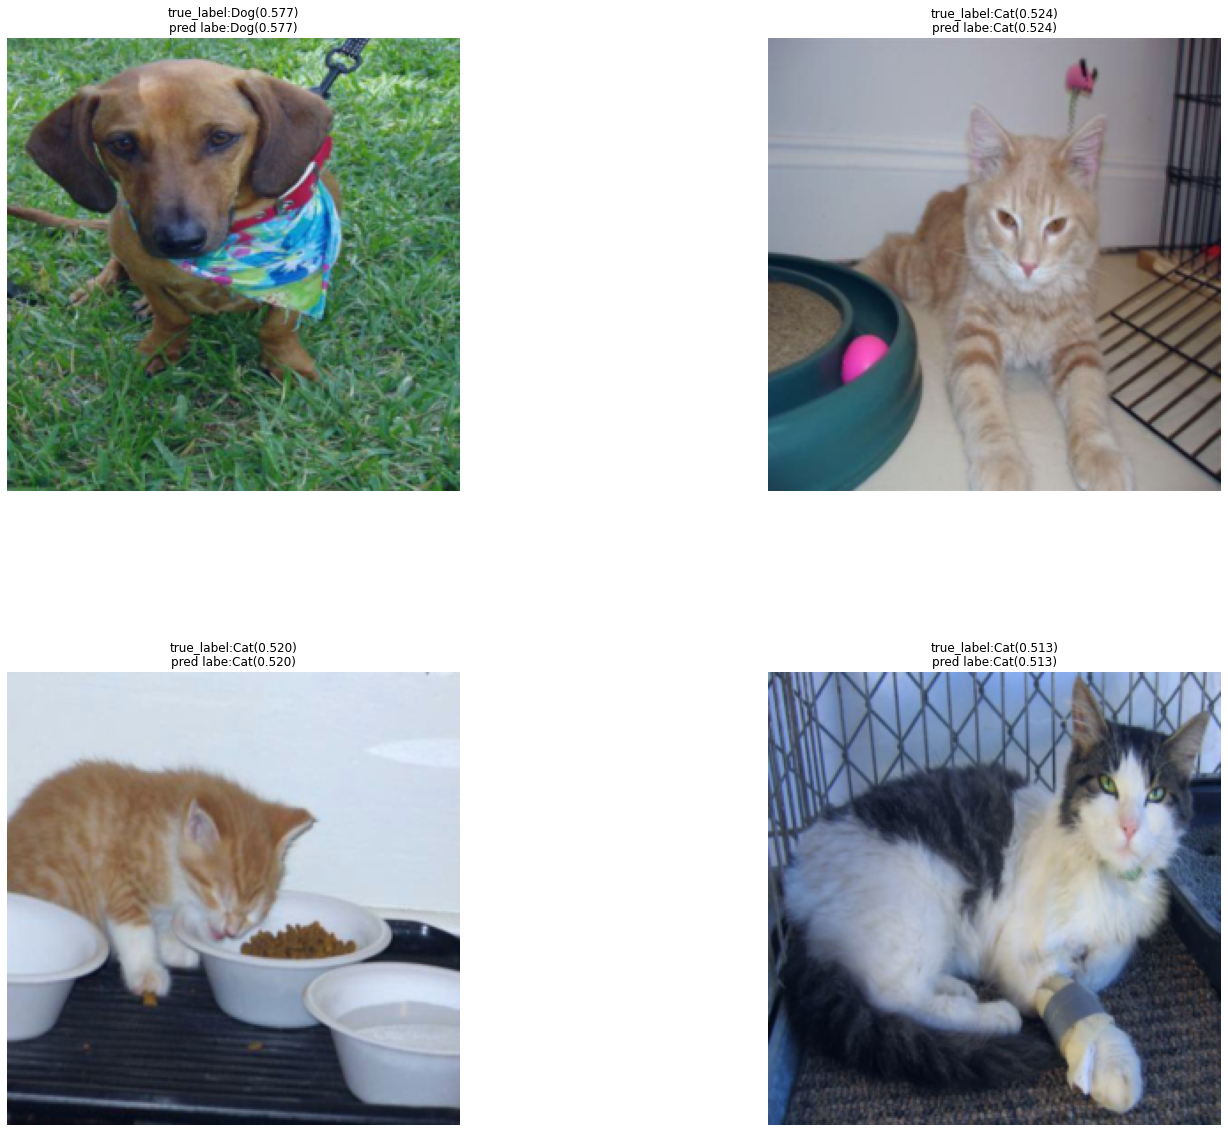

In [30]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples,classes,N_IMAGES)

6.1.5 ResNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as  data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader,Dataset
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform={
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
    def __call__(self,img,phase):
        return self.data_transform[phase](img)

In [4]:
from dataset import IMAGENET_MEAN,IMAGENET_STD
size = 224
mean = IMAGENET_MEAN
std = IMAGENET_STD
batch_size=16

In [49]:
transform=transforms.Compose([
                transforms.RandomResizedCrop(size,scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
val_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
])
train_data = torchvision.datasets.ImageNet('./dl_pytorch/imagenet/',split='train',transfomr=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)

val_data = torchvision.datasets.ImageNet('./dl_pytorch/imagenet/',split='val',transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=batch_size,shuffle=False)
#trainset = datasets.ImageFolder('./dl_pytorch/imagenet/ILSVRC/Data/CLS-LOC/train',transform=transform)
#train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

#valset = datasets.ImageFolder('./dl_pytorch/imagenet/ILSVRC/Data/CLS-LOC/val/',transform=ImageTransform(size,mean,std))
#val_loader = torch.utils.data.DataLoader(valset,batch_size=batch_size,shuffle=False)

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in ./dl_pytorch/imagenet/.

In [44]:
#dataloader_dict = {'train':train_loader,'val':val_loader}

train_iterator = iter(train_loader)
inputs,label = next(train_iterator)
print(inputs.size())
print(label)

torch.Size([16, 3, 224, 224])
tensor([ 81, 669, 554, 819,  72, 354, 259, 225, 804, 666, 822, 748, 911, 592,
        309, 750])


In [22]:
class BasicBLock(nn.Module):
    expansion = 1

    def __init__(self,in_channels,out_channels,stride=1,downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv,bn)
        else:
            downsample=None
        self.downsample=downsample

    def forward(self,x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i=self.downsample(i)

        x+=i
        x = self.relu(x)

        return x


In [23]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self,in_channels,out_channels,stride=1,downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size = 3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,self.expansion*out_channels,kernel_size=1,stride=1,bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels,self.expansion*out_channels,kernel_size=1,stride=stride,bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv,nn)
        else:
            downsample = None
        self.downsample = downsample
    def forward(self,x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x =self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x+=i
        x = self.relu(x)
        return x

In [26]:
class ResNet(nn.Module):
    def __init__(self,config,output_dim,zero_init_residual=False):
        super().__init__()

        block,n_blocks,channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4
        self.conv1 = nn.Conv2d(3,self.in_channels,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = self.get_resnet_layer(block,n_blocks[0],channels[0])
        self.layer2 = self.get_resnet_layer(block,n_blocks[1],channels[1],stride=2)
        self.layer3 = self.get_resnet_layer(block,n_blocks[2],channels[2],stride=2)
        self.layer4 = self.get_resnet_layer(block,n_blocks[3],channels[3],stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels,output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m,Bottleneck):
                    nn.init.constant_(m.bn3.weight,0)
                elif isinstance(m,BasicBLock):
                    nn.init.constant_(m.bn2.weight,0)

    def get_resnet_layer(self,block,n_blocks,channels,stride=1):
        layers=[]
        if self.in_channels != block.expansion*channels:
            downsample=True
        else:
            downsample=False

        layers.append(block(self.in_channels,channels,stride,downsample))
        for i in range(1,n_blocks):
            layers.append(block(block.expansion*channels,channels))

        self.in_channels = block.expansion*channels
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0],-1)
        x = self.fc(h)
        return x,h


In [27]:
ResNetConfig = namedtuple('ResNetConfig',['block','n_blocks','channels'])


In [28]:
#resnet 구조 정의. 50층 이상은 생략
resnet18_config = ResNetConfig(block=BasicBLock,n_blocks=[2,2,2,2],channels=[64,128,256,512])
resnet34_config = ResNetConfig(block=BasicBLock,n_blocks=[3,4,6,3],channels=[64,128,256,512])


In [32]:
OUTPUT_DIM = 1000
model = ResNet(resnet34_config,OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(),lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [31]:
def calculate_topk_accuracy(y_pred,y,k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _,top_pred = y_pred.topk(k,1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1,-1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0,keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0,keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1,acc_k


In [46]:
def train(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.train()
    for(x,y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0],y)

        acc_1,acc_5 = calculate_topk_accuracy(y_pred[0],y)
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()
        epoch_acc_1+=acc_1.item()
        epoch_acc_5+=acc_5.item()
    epoch_loss/=len(iterator)
    epoch_acc_1/=len(iterator)
    epoch_acc_5/=len(iterator)
    return epoch_loss,epoch_acc_1,epoch_acc_5

In [34]:
def evaluate(model,iterator,criterion,device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.train()
    with torch.no_grad():
        for(x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0],y)

            acc_1,acc_5 = calculate_topk_accuracy(y_pred[0],y)

            epoch_loss+=loss.item()
            epoch_acc_1+=acc_1.item()
            epoch_acc_5+=acc_5.item()
    epoch_loss/=len(iterator)
    epoch_acc_1/=len(iterator)
    epoch_acc_5/=len(iterator)
    return epoch_loss,epoch_acc_1,epoch_acc_5

In [35]:
def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time -(elapsed_mins*60))
    return elapsed_mins,elapsed_secs


In [47]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss,train_acc1,train_acc5 = train(model,train_iterator,optimizer,criterion,device)
    valid_loss,valid_acc1,valid_acc5 = evaluate(model,valid_iterator,criterion,device)

    if valid_loss< best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'./dl_pytorch/chap06/data/ResNet-model.pt')
    end_time = time.monotonic()
    epoch_mins,epoch_secs = epoch_time(start_time,end_time)

    print(f'Epoch:{epoch+1:02} | Epoch Time : {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss : {train_loss:.3f} | Train Acc @1 : {train_acc1*100:6.2f}% | '\
    f'Train Acc @5 : {train_acc5*100:6.2f}%')
    print(f'\tValid Loss : {valid_loss:.3f} | Valid Acc @1 : {valid_acc1*100:6.2f}% | '\
    f'Valid Acc @5 : {valid_acc5*100:6.2f}%')

NameError: name 'valid_iterator' is not defined